# Advanced Lane Finding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2

from lanetracker.tracker import LaneTracker
from lanetracker.camera import CameraCalibration
from lanetracker.gradients import get_edges
from lanetracker.perspective import flatten_perspective

%matplotlib inline
%load_ext autoreload
%autoreload 2

Camera calibration

In [ ]:
calibrate = CameraCalibration(glob.glob('camera_cal/calibration*.jpg'), retain_calibration_images=True)

print('Correction images (successfully detected corners):')
plt.figure(figsize = (11.5, 9))
gridspec.GridSpec(5, 4)
# Step through the list and search for chessboard corners
for i, image in enumerate(calibrate.calibration_images_success):
    plt.subplot2grid((5, 4), (i // 4, i % 4), colspan=1, rowspan=1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

print('\nTest images (failed to detect corners):')
for i, image in enumerate(calibrate.calibration_images_error):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=10)
    ax2.axis('off')
    ax2.imshow(calibrate(image))
    ax2.set_title('Calibrated', fontsize=10)

Color & gradient threshold pipeline.

In [ ]:
image = mpimg.imread('test_images/test6.jpg')
result = get_edges(image, separate_channels=True)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Original', fontsize=18)
ax2.axis('off')
ax2.imshow(result)
ax2.set_title('Edges', fontsize=18)

Perspective transform

In [ ]:
image = mpimg.imread('test_images/test6.jpg')
result, _ = flatten_perspective(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Original', fontsize=18)
ax2.axis('off')
ax2.imshow(result)
ax2.set_title('Bird\'s eye view', fontsize=18)

Finding the lines

In [ ]:
for image_name in glob.glob('test_images/*.jpg'):
    calibrated = calibrate(mpimg.imread(image_name))
    lane_tracker = LaneTracker(calibrated)
    overlay_frame = lane_tracker.process(calibrated, draw_lane=True, draw_statistics=True)
    mpimg.imsave(image_name.replace('test_images', 'output_images'), overlay_frame)
    plt.imshow(overlay_frame)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

Applying pipeline to video

In [ ]:
from moviepy.editor import VideoFileClip

video_output_name = 'video/project_video_annotated.mp4'
video = VideoFileClip("video/project_video.mp4")
tracker = LaneTracker(calibrate(video.get_frame(0)))
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

# Vehicle Tracking

Train a classifier.

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from vehicletracker.features import FeatureExtractor
from vehicletracker.utilities import print_progress

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Read training data
print('Reading data...')
cars = []
notcars = []
notcars_files = glob.glob('data/non-vehicles/*/*.png')
cars_files = glob.glob('data/vehicles/*/*.png')
for file in cars_files:
    cars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
for file in notcars_files:
    notcars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))

cars = np.asarray(cars)    
notcars = np.asarray(notcars)    
print('    ...Done')

print('Vehicles images:', cars.shape[0])
print('Non-vehicles images:', notcars.shape[0])

# Extract features
print('Extracting features...')
car_features = []
notcar_features = []
for car in cars:
    car_features.append(FeatureExtractor(car).feature_vector())
    print_progress(len(car_features) + len(notcar_features), len(cars) + len(notcars))
for notcar in notcars:
    notcar_features.append(FeatureExtractor(notcar).feature_vector())
    print_progress(len(car_features) + len(notcar_features), len(cars) + len(notcars))
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print('    ...Done')

# Perform feature scaling
print('Scaling features...')
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('    ...Done')

# Train linear SVC classifier
print('Training classifier...')
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('    ...Done')
print('Accuracy =', accuracy)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading data...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
    ...Done
Vehicles images: 8792
Non-vehicles images: 8968
Extracting features...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
    ...Done
Scaling features...
    ...Done
Training classifier...
    ...Done
Accuracy = 0.9865


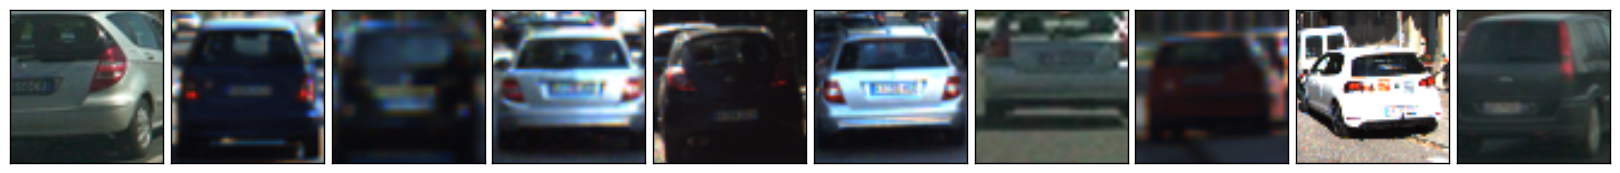

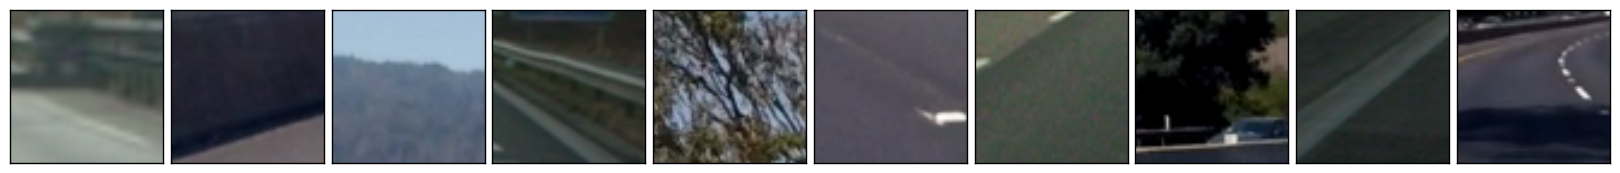

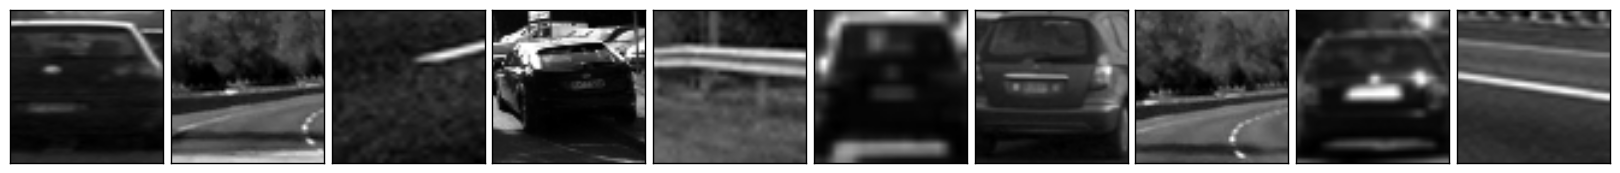

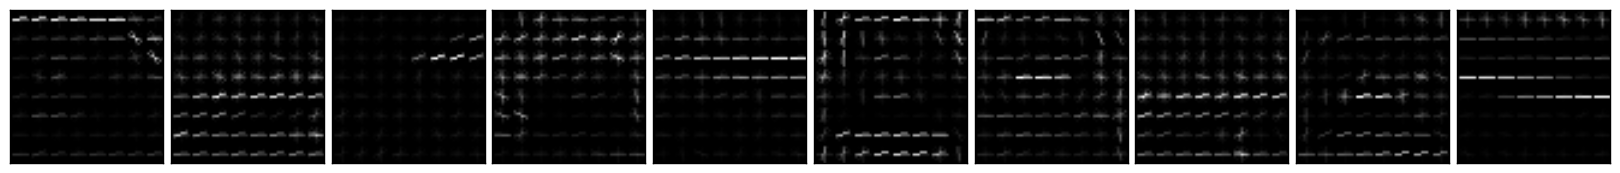

In [32]:
import random
from skimage.feature import hog

fig = plt.figure(figsize = (16, 2))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
random_indices = random.sample(range(0, cars.shape[0]), 10)
for i in range(10):
    axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    axis.imshow(cars[random_indices[i]])
plt.show()

fig = plt.figure(figsize = (16, 2))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
random_indices = random.sample(range(0, notcars.shape[0]), 10)
for i in range(10):
    axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    axis.imshow(notcars[random_indices[i]])
plt.show()

both = np.concatenate((cars, notcars))
fig = plt.figure(figsize = (16, 2))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
random_indices = random.sample(range(0, both.shape[0]), 10)
for i in range(10):
    axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    image = cv2.cvtColor(both[random_indices[i]], cv2.COLOR_RGB2YCrCb)
    axis.imshow(image[:, :, 0], cmap='gray')
plt.show()

fig = plt.figure(figsize = (16, 2))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for i in range(10):
    axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    image = cv2.cvtColor(both[random_indices[i]], cv2.COLOR_RGB2YCrCb)
    _, image = hog(image[:, :, 0], orientations=10, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True,
                    visualise=True, feature_vector=False)
    axis.imshow(image, cmap='gray')
plt.show()

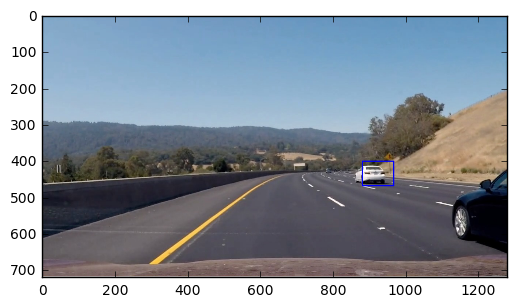

In [14]:
from vehicletracker.tracker import VehicleTracker

image = mpimg.imread('test_images/test7.jpg')
tracker = VehicleTracker(X_scaler, svc, image)
tracker.process(image, draw_detections=True)
    
plt.imshow(image)
plt.show()

In [15]:
from moviepy.editor import VideoFileClip
from vehicletracker.tracker import VehicleTracker

video_output_name = 'video/project_video_annotated_vehicles.mp4'
video = VideoFileClip("video/project_video.mp4")
tracker = VehicleTracker(X_scaler, svc, video.get_frame(0))
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

[MoviePy] >>>> Building video video/project_video_annotated_vehicles.mp4
[MoviePy] Writing video video/project_video_annotated_vehicles.mp4



100%|█████████▉| 1260/1261 [34:54<00:01,  1.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/project_video_annotated_vehicles.mp4 

CPU times: user 1h 56min 4s, sys: 55.1 s, total: 1h 56min 59s
Wall time: 34min 55s


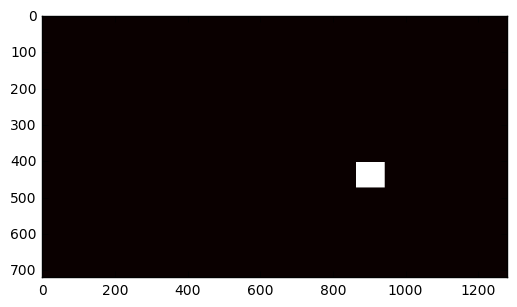

In [6]:
plt.imshow(tracker.heatmap, cmap='hot')

In [ ]:
from vehicletracker.tracker import get_regions
from vehicletracker.tracker import extract_features
from vehicletracker.tracker import add_heat
from vehicletracker.tracker import detect_features

image = (mpimg.imread('test_images/test4.jpg') / 255.).astype(np.float64)

found_coordinates = np.empty([0, 4], dtype = np.int64)

for scale in np.linspace(.2, 1., 5):
    regions_coordinates = get_regions(image, X_scaler, svc, scale=scale, k=64)
    print(regions_coordinates.shape[0], 'regions with cars')
    found_coordinates = np.append(found_coordinates, regions_coordinates, axis=0)

heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heatmap = add_heat(heatmap, found_coordinates)
# Apply threshold to help remove false positives
heatmap[heatmap < 2] = 0
heatmap = np.clip(heatmap, 0, 255)
found_coordinates = detect_features(heatmap)
    
for c in found_coordinates:
    cv2.rectangle(image, (c[0], c[1]), (c[2], c[3]), (0, 0, 1.), 2)
    
plt.imshow(image)
plt.show()